In [1]:
# Cài đặt nếu chưa có
# !pip install pandas matplotlib seaborn wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz.fuzz import token_set_ratio
from underthesea import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.auto import tqdm
tqdm.pandas() # Kích hoạt progress bar cho pandas

# Cài đặt font chữ hỗ trợ Tiếng Việt cho Matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'

print("Các thư viện đã được import thành công!")


Các thư viện đã được import thành công!


In [2]:
# Đường dẫn tới file dữ liệu
DATA_PATH = '/home/guest/Projects/DSC2025/BAN/data/vihallu-public-test.csv' # Thay 'train_set.csv' bằng tên file training thực tế của bạn

# Đọc dữ liệu
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Đọc thành công {len(df)} mẫu dữ liệu từ '{DATA_PATH}'")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file tại '{DATA_PATH}'. Vui lòng kiểm tra lại đường dẫn.")
    df = None

if df is not None:
    # In ra 5 dòng đầu tiên
    print("\n5 dòng dữ liệu đầu tiên:")
    display(df.head())

    # In thông tin tổng quan (số lượng non-null, kiểu dữ liệu)
    print("\nThông tin chung về DataFrame:")
    df.info()

    # Kiểm tra xem có giá trị null nào không
    print("\nKiểm tra giá trị bị thiếu (null):")
    print(df.isnull().sum())


Đọc thành công 1000 mẫu dữ liệu từ '/home/guest/Projects/DSC2025/BAN/data/vihallu-public-test.csv'

5 dòng dữ liệu đầu tiên:


,id,context,prompt,response,predict_label
0,b709059b-b3b6-4ac2-bb88-2c794e2cc219,"Putin ngày 14 tháng 10 năm 2009, đưa ra đề ngh...",Ý nhĩa cũa viẹc tổ chưc cuôc thi Intervision l...,"Cuộc thi Intervision, dự kiến lấy cảm hứng từ ...",NaN
1,7dc35ef5-c4b7-4538-ab90-627b9cbd896e,"Thông qua những quyết nghị này, Viện nguyên lã...",Quyền lực của Viện nguyên lão đã giảm mạnh khi...,"Sai. Thực tế, Viện nguyên lão vẫn duy trì quyề...",NaN
2,cfdfa010-f61c-4845-91c9-23f79be2b88b,Nơi cư ngụ truyền thống Mông Cổ được gọi là mộ...,Theo quan điểm của ai thì kiến trúc truyền thố...,"Ngoài N. Chultem, một số học giả như nhà sử họ...",NaN
3,31b33c97-2f59-4e72-8707-f47de204d7f9,Là thành phố thủ đô và có vị trí ở khu vực tru...,Hà Nội hiện nay có tuyến đường sắt quốc tế kết...,Hà Nội hiện nay có tuyến đường sắt quốc tế trự...,NaN
4,a2c83a00-e8b7-4236-86ce-5e0104df074a,Từ 1974 đến nay tốc độ phát triển tuy chậm lại...,Câu hỏi gài bẫy: Tiền đề để trở thành một quốc...,Tiền đề để Nhật Bản trở thành quốc gia cho vay...,NaN



Thông tin chung về DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1000 non-null   object 
 1   context        1000 non-null   object 
 2   prompt         1000 non-null   object 
 3   response       1000 non-null   object 
 4   predict_label  0 non-null      float64
dtypes: float64(1), object(4)
memory usage: 39.2+ KB

Kiểm tra giá trị bị thiếu (null):
id                  0
context             0
prompt              0
response            0
predict_label    1000
dtype: int64


In [3]:
# if df is not None:
#     # 1. Phân tích phân bổ nhãn
#     print("--- Phân tích Phân bổ Nhãn ---")
#     label_counts = df['label'].value_counts()
    
#     print("\nSố lượng mẫu mỗi lớp:")
#     print(label_counts)

#     # 2. Vẽ biểu đồ
#     plt.figure(figsize=(10, 6))
#     ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis', order=['no', 'extrinsic', 'intrinsic'])
#     plt.title('Phân bổ nhãn trong bộ dữ liệu Training ({} mẫu)'.format(len(df)), fontsize=16)
#     plt.xlabel('Loại nhãn', fontsize=12)
#     plt.ylabel('Số lượng mẫu', fontsize=12)
    
#     # Thêm số lượng trên mỗi cột
#     for p in ax.patches:
#         ax.annotate(f'{int(p.get_height())}\n({p.get_height()/len(df):.1%})', 
#                     (p.get_x() + p.get_width() / 2., p.get_height()), 
#                     ha = 'center', va = 'center', 
#                     xytext = (0, 9), 
#                     textcoords = 'offset points')
    
#     plt.show()

#     # 3. Tính toán trọng số lớp (Class Weights)
#     print("\n--- Tính toán Trọng số Lớp (Class Weights) ---")
#     # Công thức: weight_c = TotalSamples / (NumClasses * count_c)
#     # Đây là công thức phổ biến từ scikit-learn
#     num_classes = len(label_counts)
#     total_samples = len(df)
    
#     weights = total_samples / (num_classes * label_counts)
    
#     # Chuẩn hóa lại để trọng số của lớp nhỏ nhất là ~1.0 (tùy chọn, nhưng dễ nhìn)
#     # normalized_weights = weights / weights.min()

#     print("Trọng số tính toán cho mỗi lớp (để dùng trong PyTorch):")
#     # Sắp xếp theo thứ tự label_id 0, 1, 2 ('no', 'extrinsic', 'intrinsic')
#     label_map = {'no': 0, 'extrinsic': 1, 'intrinsic': 2}
#     sorted_labels = sorted(label_map, key=label_map.get)
#     class_weights_ordered = weights.loc[sorted_labels]

#     print(class_weights_ordered)
    
#     # Chuyển thành list để dễ dàng sử dụng trong PyTorch
#     class_weights_list = class_weights_ordered.tolist()
#     print(f"\nList trọng số để đưa vào CrossEntropyLoss: {class_weights_list}")



--- Phân tích Độ dài Văn bản (theo số từ) ---

Thống kê mô tả độ dài văn bản:


,context_len,prompt_len,response_len,combined_len
count,1000.000000,1000.000000,1000.00000,1000.000000
mean,179.447000,26.805000,39.78300,246.035000
std,68.910085,13.032913,9.64349,73.156652
min,88.000000,3.000000,5.00000,138.000000
50%,159.000000,26.000000,41.00000,229.000000
90%,261.100000,44.000000,51.00000,333.000000
95%,312.100000,50.000000,54.00000,384.050000
99%,401.000000,60.000000,61.00000,480.070000
max,671.000000,73.000000,66.00000,737.000000


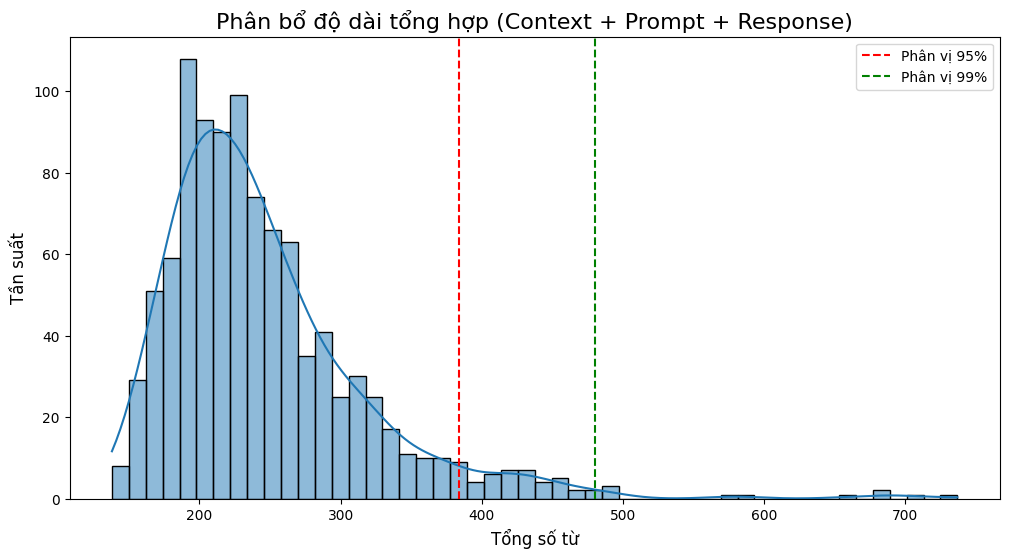

In [4]:
if df is not None:
    print("\n--- Phân tích Độ dài Văn bản (theo số từ) ---")
    # Tính toán độ dài (bỏ qua các giá trị NaN nếu có)
    df['context_len'] = df['context'].dropna().str.split().str.len()
    df['prompt_len'] = df['prompt'].dropna().str.split().str.len()
    df['response_len'] = df['response'].dropna().str.split().str.len()
    df['combined_len'] = df['context_len'] + df['prompt_len'] + df['response_len']

    # In ra thống kê mô tả chi tiết
    print("\nThống kê mô tả độ dài văn bản:")
    display(df[['context_len', 'prompt_len', 'response_len', 'combined_len']].describe(percentiles=[.90, .95, .99]))

    # Vẽ biểu đồ phân bổ của độ dài tổng hợp
    plt.figure(figsize=(12, 6))
    sns.histplot(df['combined_len'], bins=50, kde=True)
    plt.title('Phân bổ độ dài tổng hợp (Context + Prompt + Response)', fontsize=16)
    plt.xlabel('Tổng số từ', fontsize=12)
    plt.ylabel('Tần suất', fontsize=12)
    plt.axvline(df['combined_len'].quantile(0.95), color='red', linestyle='--', label='Phân vị 95%')
    plt.axvline(df['combined_len'].quantile(0.99), color='green', linestyle='--', label='Phân vị 99%')
    plt.legend()
    plt.show()


In [5]:
# if df is not None:
#     pd.set_option('display.max_colwidth', None) # Hiển thị toàn bộ nội dung cột

#     print("\n--- Ví dụ cho nhãn 'intrinsic' (Mâu thuẫn) ---")
#     display(df[df['label'] == 'intrinsic'].sample(2))

#     print("\n--- Ví dụ cho nhãn 'extrinsic' (Bịa đặt) ---")
#     display(df[df['label'] == 'extrinsic'].sample(2))
    
#     print("\n--- Ví dụ về Prompt nhiễu (Noisy Prompt) ---")
#     # Tìm các prompt có chứa ký tự đặc biệt hoặc có vẻ sai chính tả
#     noisy_prompts = df[df['prompt'].str.contains('\?{2,}|[^\w\s\u00C0-\u1EF9,.]', regex=True, na=False)]
#     display(noisy_prompts.sample(min(3, len(noisy_prompts))))


In [6]:
# if df is not None:
#     print("\n--- Phân tích Độ tương đồng văn bản (Token Set Ratio) ---")

#     # Tính toán độ tương đồng giữa context và response
#     # token_set_ratio rất hiệu quả vì nó bỏ qua thứ tự từ và từ lặp lại
#     df['similarity_score'] = df.progress_apply(
#         lambda row: token_set_ratio(str(row['context']), str(row['response'])),
#         axis=1
#     )

#     # Vẽ biểu đồ boxplot
#     plt.figure(figsize=(12, 8))
#     sns.boxplot(x='label', y='similarity_score', data=df, order=['no', 'intrinsic', 'extrinsic'], palette='coolwarm')
#     plt.title('Độ tương đồng (Context-Response) theo từng Nhãn', fontsize=16)
#     plt.xlabel('Nhãn', fontsize=12)
#     plt.ylabel('Điểm tương đồng (0-100)', fontsize=12)
#     plt.show()

#     print("\n👉 Insight:")
#     print("- Lớp 'no' có độ tương đồng cao và ổn định nhất, vì câu trả lời bám sát context.")
#     print("- Lớp 'intrinsic' có độ tương đồng khá cao nhưng phân tán, vì nó vẫn dùng từ trong context nhưng 'bóp méo' chúng.")
#     print("- Lớp 'extrinsic' có độ tương đồng thấp nhất, vì nó 'bịa' thêm thông tin mới.")
#     print("=> Độ tương đồng là một feature rất mạnh để phân biệt các lớp!")


In [8]:
# import re

# def count_new_numbers(row):
#     """Đếm số lượng các con số chỉ xuất hiện trong response."""
#     # Regex để tìm tất cả các chuỗi số (bao gồm cả dấu phẩy, chấm)
#     context_numbers = set(re.findall(r'\b\d[\d,.]*\b', str(row['context'])))
#     response_numbers = set(re.findall(r'\b\d[\d,.]*\b', str(row['response'])))
    
#     # Trả về số lượng số trong response mà không có trong context
#     return len(response_numbers - context_numbers)

# if df is not None:
#     print("\n--- Phân tích sự xuất hiện của 'Số Mới' trong Response ---")
#     df['new_numbers_count'] = df.progress_apply(count_new_numbers, axis=1)

#     # Tạo một cột boolean để phân tích dễ hơn
#     df['has_new_number'] = df['new_numbers_count'] > 0

#     # Vẽ biểu đồ crosstab
#     crosstab = pd.crosstab(df['has_new_number'], df['label'], normalize='index')
    
#     ax = crosstab.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='plasma', rot=0)
#     plt.title('Tỷ lệ Nhãn khi Response có/không có "Số Mới"', fontsize=16)
#     plt.xlabel('Response có chứa "Số Mới" không?', fontsize=12)
#     plt.ylabel('Tỷ lệ', fontsize=12)
#     plt.xticks([0, 1], ['Không', 'Có'])

#     # Thêm chú thích phần trăm
#     for c in ax.containers:
#         ax.bar_label(c, fmt='{:.1%}', label_type='center')
        
#     plt.show()

#     print("\n👉 Insight:")
#     print("Khi response KHÔNG chứa số mới, phần lớn là nhãn 'no'.")
#     print("Khi response CÓ chứa số mới, tỷ lệ ảo giác (đặc biệt là 'intrinsic' và 'extrinsic') tăng vọt.")
#     print("=> Feature 'has_new_number' là một tín hiệu cực kỳ mạnh để phát hiện hallucination.")


In [10]:
# ADVERSARIAL_KEYWORDS = [
#     "mặc dù", "thực sự", "đúng không", "phải không", "đúng hay sai", 
#     "có phải", "vốn không", "ngoài... ra", "thay vì"
# ]

# def has_adversarial_keyword(prompt):
#     prompt_lower = str(prompt).lower()
#     return any(keyword in prompt_lower for keyword in ADVERSARIAL_KEYWORDS)

# if df is not None:
#     print("\n--- Phân tích ảnh hưởng của 'Prompt Gài bẫy' ---")
#     df['is_adversarial_prompt'] = df['prompt'].apply(has_adversarial_keyword)

#     crosstab_prompt = pd.crosstab(df['is_adversarial_prompt'], df['label'], normalize='index')
    
#     ax = crosstab_prompt.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='cividis', rot=0)
#     plt.title('Tỷ lệ Nhãn khi Prompt có/không có "Từ khóa Gài bẫy"', fontsize=16)
#     plt.xlabel('Prompt có chứa "Từ khóa Gài bẫy" không?', fontsize=12)
#     plt.ylabel('Tỷ lệ', fontsize=12)
#     plt.xticks([0, 1], ['Không (Factual/Noisy)', 'Có (Adversarial)'])
    
#     for c in ax.containers:
#         ax.bar_label(c, fmt='{:.1%}', label_type='center')
        
#     plt.show()
    
#     print("\n👉 Insight:")
#     print("Các prompt 'gài bẫy' có xu hướng làm tăng nhẹ tỷ lệ ảo giác, đặc biệt là 'intrinsic'.")
#     print("Điều này cho thấy mô hình cần học cách tin tưởng 'context' hơn là các tiền đề sai trong 'prompt'.")


In [12]:
# def get_top_ngrams(corpus, n=2, top_k=15):
#     """Trích xuất các n-gram phổ biến nhất từ một kho văn bản."""
#     vec = CountVectorizer(ngram_range=(n, n), stop_words=None).fit(corpus)
#     bag_of_words = vec.transform(corpus)
#     sum_words = bag_of_words.sum(axis=0) 
#     words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
#     words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
#     return words_freq[:top_k]

# if df is not None:
#     print("\n--- Phân tích N-gram phổ biến trong Response bị lỗi ---")
    
#     # Lọc ra các response của từng loại lỗi
#     intrinsic_responses = df[df['label'] == 'intrinsic']['response'].dropna()
#     extrinsic_responses = df[df['label'] == 'extrinsic']['response'].dropna()

#     # Lấy top bi-grams (cụm 2 từ)
#     top_intrinsic_bigrams = get_top_ngrams(intrinsic_responses, n=2)
#     top_extrinsic_bigrams = get_top_ngrams(extrinsic_responses, n=2)

#     # Tạo DataFrame để hiển thị
#     df_bigrams = pd.DataFrame({
#         'Top Intrinsic Bi-grams': [f"{gram} ({count})" for gram, count in top_intrinsic_bigrams],
#         'Top Extrinsic Bi-grams': [f"{gram} ({count})" for gram, count in top_extrinsic_bigrams]
#     })
    
#     print("\nTop 15 Bi-grams (cụm 2 từ) phổ biến nhất:")
#     display(df_bigrams)

#     print("\n👉 Insight:")
#     print("Phân tích n-gram có thể hé lộ các 'cụm từ ảo giác' phổ biến mà mô hình sinh ra.")
#     print("Ví dụ: 'Ngoài ra', 'Thực tế', 'Tuy nhiên' có thể là dấu hiệu bắt đầu của một câu 'bịa' thêm (extrinsic).")


In [ ]:
# import nltk

# # Tải công cụ tách câu của NLTK (chỉ cần chạy lần đầu)
# # Tải công cụ tách câu của NLTK (chỉ cần chạy lần đầu)
# try:
#     nltk.data.find('tokenizers/punkt')
# except LookupError: # <<< SỬA Ở ĐÂY: Bắt đúng lỗi LookupError
#     print("Đang tải tài nguyên 'punkt' của NLTK...")
#     nltk.download('punkt')
#     print("Tải thành công!")

# from nltk.tokenize import sent_tokenize

# def find_least_similar_sentence(context, response):
#     """
#     Tách response thành các câu và tìm câu có độ tương đồng thấp nhất với context.
#     Trả về câu đó và độ dài (số từ) của nó.
#     """
#     # Xử lý các trường hợp input không phải là chuỗi
#     context_str = str(context) if pd.notna(context) else ""
#     response_str = str(response) if pd.notna(response) else ""

#     if not response_str.strip():
#         return "", 0, 100 # Trả về giá trị mặc định nếu response rỗng

#     try:
#         sentences = sent_tokenize(response_str)
#     except Exception as e:
#         # Xử lý nếu sent_tokenize bị lỗi với một chuỗi kỳ lạ
#         return response_str, len(response_str.split()), 0 

#     if not sentences:
#         return "", 0, 100

#     min_score = 101
#     least_similar_sent = ""

#     for sent in sentences:
#         if len(sent.split()) < 2:
#             continue
#         score = token_set_ratio(context_str, sent)
#         if score < min_score:
#             min_score = score
#             least_similar_sent = sent
            
#     if least_similar_sent == "": # Nếu tất cả các câu đều quá ngắn
#         return response_str, len(response_str.split()), token_set_ratio(context_str, response_str)
        
#     return least_similar_sent, len(least_similar_sent.split()), min_score

# if 'label' in df.columns:
#     print("\n--- Phân tích Sâu Lớp 'extrinsic' ---")
#     df_extrinsic = df[df['label'] == 'extrinsic'].copy()

#     # Áp dụng hàm để tìm câu bịa đặt (có thể mất một chút thời gian)
#     tqdm.pandas(desc="Analyzing extrinsic sentences")
#     extrinsic_info = df_extrinsic.progress_apply(
#         lambda row: find_least_similar_sentence(row['context'], row['response']),
#         axis=1
#     )
#     df_extrinsic[['hallucinated_sentence', 'hallucinated_len', 'min_similarity']] = pd.DataFrame(extrinsic_info.tolist(), index=df_extrinsic.index)

#     # Vẽ biểu đồ phân bổ độ dài của thông tin bịa thêm
#     plt.figure(figsize=(12, 6))
#     sns.histplot(df_extrinsic['hallucinated_len'], bins=30, kde=True)
#     plt.title('Phân bổ Độ dài (số từ) của Thông tin "Bịa" thêm trong Lớp Extrinsic', fontsize=16)
#     plt.xlabel('Số từ trong câu bịa đặt', fontsize=12)
#     plt.ylabel('Tần suất', fontsize=12)
#     plt.show()

#     print("\nVí dụ các câu 'bịa đặt' ngắn nhất được tìm thấy:")
#     display(df_extrinsic.sort_values('hallucinated_len').head(5)[['context', 'response', 'hallucinated_sentence']])
    
#     print("\n👉 Insight:")
#     print("Biểu đồ này cho thấy mô hình phải đối mặt với các lỗi 'extrinsic' ở mọi độ dài.")
#     print("Nếu biểu đồ lệch về bên trái (nhiều câu ngắn), điều đó xác nhận rằng các lỗi tinh vi, ngắn gọn là một thách thức lớn.")
